# Netflix Stock Price Prediction Using LSTM and XGBoost


# **Group 3**

**Members**


1.   Henry Mwangi
2.   Zuenna Kiezy
3.   Loryne Muthoni
4.   Isaac Onyach
5.   Apphia Keino














**Tasks:**

**1. Data Preprocessing**


In [ ]:
!pip install scikeras
!pip install keras-tuner
!pip install shap
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import keras_tuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.8 MB/s eta 0:00:00


**• Load and explore the dataset**

In [ ]:
# Loads the dataset
df= pd.read_csv('/content/Netflix Inc. (NFLX) Stock Price 2002-2025.csv')

In [ ]:
# Checking the rows and columns of the data - shape
df.shape

(5729, 7)

In [ ]:
# Viewing the first five rows of the dataset
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Feb 25, 2025",989.4,994.4,955,977.24,977.24,"4,733,000"
1,"Feb 24, 2025","1,008.00","1,015.17",984.48,988.47,988.47,"4,426,200"
2,"Feb 21, 2025","1,029.42","1,032.38",999.39,"1,003.15","1,003.15","3,738,700"
3,"Feb 20, 2025","1,042.00","1,045.00","1,015.59","1,024.54","1,024.54","3,111,800"
4,"Feb 19, 2025","1,035.18","1,045.00","1,024.51","1,043.33","1,043.33","2,600,000"


In [ ]:
# Viewing the last five rows of the dataset
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5724,"May 30, 2002",1.11,1.11,1.07,1.07,1.07,"10,154,200"
5725,"May 29, 2002",1.16,1.16,1.09,1.1,1.1,"6,757,800"
5726,"May 28, 2002",1.21,1.23,1.16,1.16,1.16,"6,609,400"
5727,"May 24, 2002",1.21,1.23,1.2,1.21,1.21,"11,104,800"
5728,"May 23, 2002",1.16,1.24,1.15,1.2,1.2,"104,790,000"


In [ ]:
# Checking the overall information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       5729 non-null   object
 1   Open       5729 non-null   object
 2   High       5727 non-null   object
 3   Low        5727 non-null   object
 4   Close      5727 non-null   object
 5   Adj Close  5727 non-null   object
 6   Volume     5727 non-null   object
dtypes: object(7)
memory usage: 313.4+ KB


In [ ]:
#Outputs the titles of the columns
df.columns

Index(['Date', 'Open ', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

**• Handle missing values and perform data cleaning.**

In [ ]:
#Removes whitespace from the column Open making it accessible
df.columns=df.columns.str.strip()

In [ ]:
#Gets the count of unique values in the Open column
df['Open'].value_counts()

,count
Open,
1.63,14
3.96,14
2.86,14
3.95,12
3.86,11
...,...
355.41,1
355.5,1
358.01,1


In [ ]:
#Checking for missing values in the colums
df.isnull().sum()

,0
Date,0
Open,0
High,2
Low,2
Close,2
Adj Close,2
Volume,2


In [ ]:
#Checks for rows with missing values
df[df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
2418,"Jul 15, 2015",7:1 Stock Splits,NaN,NaN,NaN,NaN,NaN
5293,"Feb 12, 2004",2:1 Stock Splits,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Foward fills the nan values
df.fillna(method= 'ffill', inplace= True)


<ipython-input-12-0855d5fa60d1>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method= 'ffill', inplace= True)


In [ ]:
# Checking if all missing values have been handled
df.isnull().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [ ]:
#Changes the date format to datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

<ipython-input-14-d3aa7e11c001>:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


In [ ]:
# List of columns to clean
cols_to_clean = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Remove commas and convert to numeric
for col in cols_to_clean:
    df[col] = df[col].str.replace(',', '', regex=True)

In [ ]:
#Checks the overall information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5729 non-null   datetime64[ns]
 1   Open       5729 non-null   object        
 2   High       5729 non-null   object        
 3   Low        5729 non-null   object        
 4   Close      5729 non-null   object        
 5   Adj Close  5729 non-null   object        
 6   Volume     5729 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 313.4+ KB


In [ ]:
#Replaces the stocksplits with nan values
df["Open"]=df["Open"].replace({"7:1 Stock Splits":np.nan})
df["Open"]=df["Open"].replace({"2:1 Stock Splits":np.nan})

In [ ]:
#Forward fills the nan values
df.fillna(method="ffill",inplace=True)

<ipython-input-18-8ee9296d4a77>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="ffill",inplace=True)


In [ ]:
#Converts columns to be of type float
for col in cols_to_clean:
  df[col]=df[col].astype(float)

In [ ]:
#Converts the volume column to integer
df.Volume=df.Volume.astype(int)

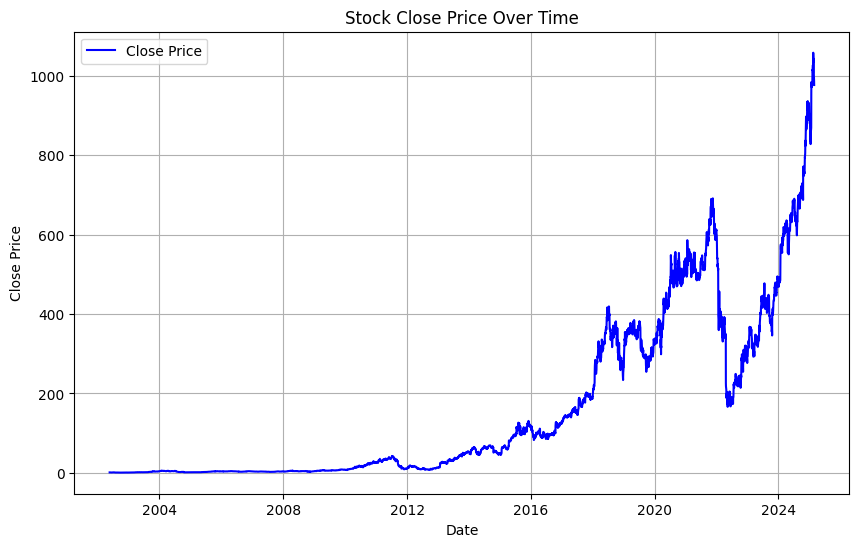

In [ ]:
df.set_index('Date', inplace=True)

# Plot the Close column over time
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

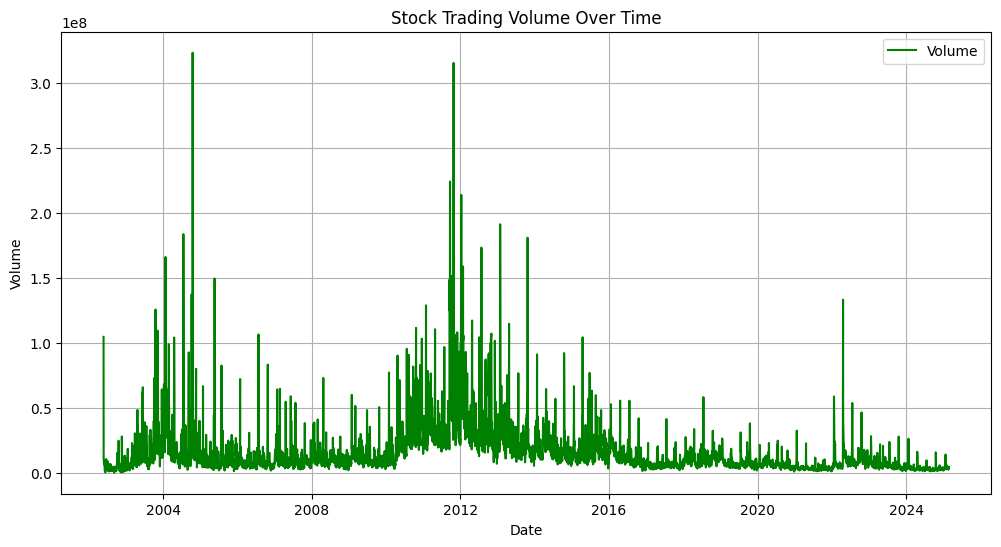

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], label='Volume', color='green')
plt.title('Stock Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

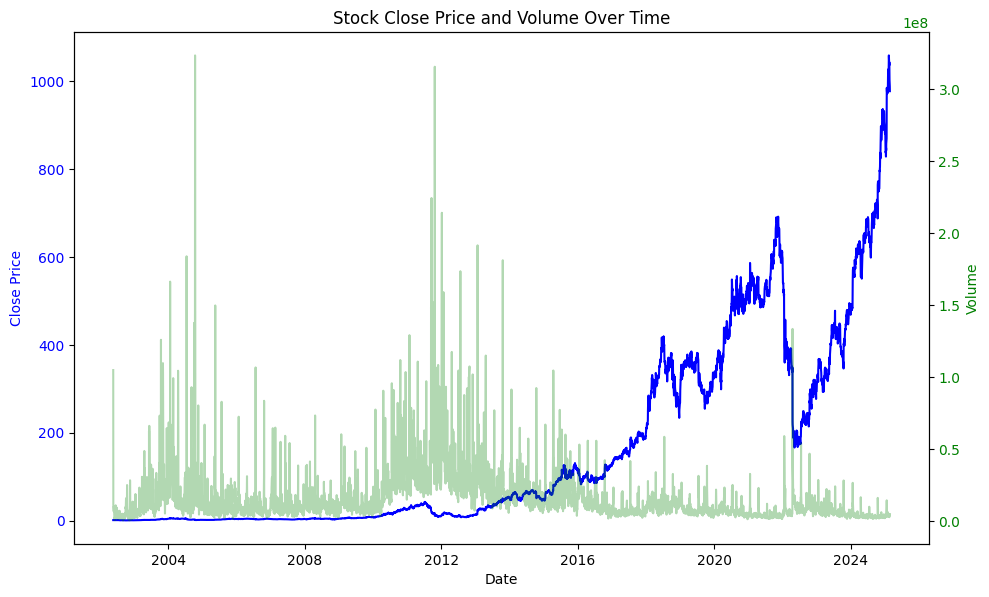

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Close Price
ax1.plot(df['Close'], color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second axis for volume
ax2 = ax1.twinx()
ax2.plot(df['Volume'], color='green', label='Volume', alpha=0.3)
ax2.set_ylabel('Volume', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.tight_layout()
plt.title('Stock Close Price and Volume Over Time')
plt.show()

**• Perform feature scaling and normalization where necessary.**

In [ ]:
df = df.reset_index('Date')
#Identify Numerical Columns:
numerical_columns=df.select_dtypes(include=np.number).columns
#Extract Date Column:
date_col=df["Date"]
#Initialize MinMaxScaler:
sc=MinMaxScaler(feature_range=(-1,1))
#Scale Numerical Columns:
numerical_scaled=sc.fit_transform(df[numerical_columns])
#Create Scaled DataFrame:
scaled_df=pd.DataFrame(numerical_scaled,columns=numerical_columns)
#Add Date Column to Scaled DataFrame:
scaled_df["Date"]=date_col.values

In [ ]:
#Outputing the first five rows of the scaled datafame
scaled_df.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.866745,0.868244,0.833503,0.846234,0.846234,-0.972473,2025-02-25
1,0.901852,0.907282,0.890122,0.867458,0.867458,-0.974372,2025-02-24
2,0.942281,0.939629,0.918759,0.895202,0.895202,-0.978627,2025-02-21
3,0.966026,0.963349,0.949872,0.935628,0.935628,-0.982507,2025-02-20
4,0.953153,0.963349,0.967004,0.971140,0.971140,-0.985675,2025-02-19


# 2. Feature Engineering

**• Create new relevant features from the existing dataset.**

In [ ]:
# Calculate Percentage Return:
scaled_df["return_percentage"]=scaled_df["Close"].pct_change() # This line calculates the percentage change in the "Close" column and stores the result in a new column called "return_percentage".
scaled_df["trading_range"]=(scaled_df["High"] - scaled_df["Low"])/ scaled_df["Low"] # This calculates the trading range as the difference between the "High" and "Low" prices, divided by the "Low" price.
scaled_df['price_movement']=(scaled_df["Close"] - scaled_df["Open"])/scaled_df["Open"] # This calculates the relative price movement from the "Open" to the "Close" price.

In [ ]:
# These two lines create sine and cosine features representing the day of the week.
scaled_df["day_sin"]=np.sin(2* np.pi* scaled_df["Date"].dt.dayofweek/7)
scaled_df["day_cos"]=np.cos(2*np.pi* scaled_df["Date"].dt.dayofweek /7)

# These two lines create sine and cosine features representing the month of the year.
scaled_df["month_sin"]=np.sin(2* np.pi* scaled_df["Date"].dt.month /12)
scaled_df["month_cos"]=np.cos(2*np.pi* scaled_df["Date"].dt.month /12)

# This line removes the original "Date" column from the DataFrame 'scaled_df'.
scaled_df.drop("Date",axis=1,inplace=True)

**• Utilize lagged variables for time series forecasting.**

In [ ]:
#Creates Lag features
scaled_df["lag_1"]=scaled_df["Close"].shift(1)
scaled_df["lag_2"]=scaled_df["Close"].shift(2)
scaled_df["lag_3"]=scaled_df["Close"].shift(3)

**• Implement rolling statistics such as moving averages.**

In [ ]:
#Rolling statistics - Standard Deviation
scaled_df["rolling_std_5"] = scaled_df["Close"].rolling(5).std()

In [ ]:
#Rolling statistics - Moving Average
scaled_df["rolling_average"]=scaled_df["Close"].rolling(5).mean()

In [ ]:
#Outputs first five rows of the scaled dataframe
scaled_df.head(5)

,Open,High,Low,Close,Adj Close,Volume,return_percentage,trading_range,price_movement,day_sin,day_cos,month_sin,month_cos,lag_1,lag_2,lag_3,rolling_std_5,rolling_average
0,0.866745,0.868244,0.833503,0.846234,0.846234,-0.972473,NaN,0.041681,-0.023664,0.781831,0.623490,0.866025,0.5,NaN,NaN,NaN,NaN,NaN
1,0.901852,0.907282,0.890122,0.867458,0.867458,-0.974372,0.025081,0.019278,-0.038137,0.000000,1.000000,0.866025,0.5,0.846234,NaN,NaN,NaN,NaN
2,0.942281,0.939629,0.918759,0.895202,0.895202,-0.978627,0.031984,0.022716,-0.049963,-0.433884,-0.900969,0.866025,0.5,0.867458,0.846234,NaN,NaN,NaN
3,0.966026,0.963349,0.949872,0.935628,0.935628,-0.982507,0.045158,0.014188,-0.031466,0.433884,-0.900969,0.866025,0.5,0.895202,0.867458,0.846234,NaN,NaN
4,0.953153,0.963349,0.967004,0.971140,0.971140,-0.985675,0.037955,-0.003780,0.018872,0.974928,-0.222521,0.866025,0.5,0.935628,0.895202,0.867458,0.050631,0.903133


In [ ]:
#Checking for NaN values in the scaled dataframe
scaled_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
return_percentage,1
trading_range,0
price_movement,0
day_sin,0


In [ ]:
#Backward filling the NaN values
scaled_df.fillna(method= 'bfill', inplace= True)

<ipython-input-33-8c9d413c511e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  scaled_df.fillna(method= 'bfill', inplace= True)


In [ ]:
#Confirmin the Nan values have been filled
scaled_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0
return_percentage,0
trading_range,0
price_movement,0
day_sin,0


# 3. Hybrid Modeling Approach

**• Develop an LSTM model to capture temporal dependencies in stock prices.**

In [ ]:
#Drops the Open column
scaled_df=scaled_df.drop("Open",axis=1)

In [ ]:
# This line creates a new DataFrame named 'feature' by dropping the "Close" column from the 'scaled_df' DataFrame.
feature =scaled_df.drop("Close",axis=1)

# This line creates a pandas Series named 'target' that contains the "Close" column from the 'scaled_df' DataFrame.
target =scaled_df["Close"]

In [ ]:
#Creates sequences of features and corresponding target values for time series prediction.
def create_sequences(data, target, n_steps=60):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(target[i+n_steps])  # Next Close price
    return np.array(X), np.array(y)

X, y = create_sequences(feature, target,n_steps=60) # This line calls the 'create_sequences' function to generate the input sequences (X) and target values (y).

In [ ]:
#Prints the shape of the NumPy array X
print(X.shape)

(5669, 60, 16)


In [ ]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# This line of code will print the shape of the X_train NumPy array.
X_train.shape

(4535, 60, 16)

In [ ]:
#  This line of code will print the shape of the X_test NumPy array.
X_test.shape

(1134, 60, 16)

In [ ]:
# Define the LSTM Model Architecture
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X.shape[1], X.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Trains the LSTM model using the provided training data.
lstm_model.fit(X, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 17794.2441 - val_loss: 0.1292
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 591759.2500 - val_loss: 134.4093
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 369195.6250 - val_loss: 21.8172
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 27647.1562 - val_loss: 19.4730
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 68608.6016 - val_loss: 8.5090
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 6445.4150 - val_loss: 8.8851
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 5349.3003 - val_loss: 3.2443
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1960.9458 - val_loss: 2.6248
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 3774.3931 - val_loss: 2.3276
Epoch 10/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 2775.6609 - val_loss: 2.1230
Epoch 11/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5858.1763 - val_loss: 1.9

In [ ]:
# Generate Predictions Using the LSTM Model:
predicted_lstm= lstm_model.predict(X_test)

# Calculate Mean Squared Error (MSE):
mae= mean_squared_error(y_test,predicted_lstm)
print(f"Mean Squared Error: {mae}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Mean Squared Error: 0.3888977717066041


**• Additionally, students must implement another model (e.g., XGBoost, ARIMA, Random
Forest) alongside LSTM for comparison.**

In [ ]:
# Reshapes the 3D training feature data (X_train) into a 2D array.
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Reshapes the 1D training target data (y_train) into a 2D array with a single column.
y_train_2d = y_train.reshape(y_train.shape[0], -1)
y_test_2d = y_test.reshape(y_test.shape[0], -1)

In [ ]:
XGB_model= XGBRegressor(n_estimators=1000,learning_rate=0.01) # Initialize XGBoost Regressor Model:
XGB_model.fit(X_train_2d,y_train_2d) # Trains the XGBoost model
predicted_xgb= XGB_model.predict(X_test_2d) # Generate Predictions Using the XGBoost Model:
mae= mean_squared_error(y_test_2d,predicted_xgb) # Calculate Mean Squared Error (MSE):
print(f"Mean Squared Error: {mae}")

Mean Squared Error: 0.00011678733747365943


**Combine the models effectively for improved prediction accuracy.**

In [ ]:
# Stack the predictions
combined_predictions = np.column_stack((predicted_lstm, predicted_xgb))
print(combined_predictions)

[[-0.68807685 -0.95582855]
 [-0.83364207 -0.99708337]
 [-0.6819186  -0.71539867]
 ...
 [-0.8318526  -0.98848283]
 [-0.44517678 -0.50782263]
 [-0.80604607 -0.9978905 ]]


# 4. Hyperparameter Optimization

• Optmize model parameters.

• Tune hyperparameters for both LSTM and the additional chosen model to improve
performance.


In [ ]:
import tensorflow as tf

#Optimizing the LSTM using Optuna
def objective_lstm(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    model = Sequential()
    for i in range(n_layers):
        model.add(LSTM(
            n_units,
            return_sequences=(i < n_layers - 1),
            input_shape=(X.shape[1], X.shape[2])
        ))
        model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')

    # Ensure X_train and y_train have the same number of samples
    min_samples = min(X_train.shape[0], y_train.shape[0])
    X_train_trimmed = X_train[:min_samples]
    y_train_trimmed = y_train[:min_samples]

    model.fit(
        X_train_trimmed, y_train_trimmed,  # Use trimmed data for training
        epochs=20,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=0
    )
    return model.evaluate(X_test, y_test, verbose=0)

study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(objective_lstm, n_trials=1)

[I 2025-04-24 04:05:57,957] A new study created in memory with name: no-name-d15ecdf7-1d32-4a2e-8bd6-e8e33fc3efde
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-04-24 04:08:39,639] Trial 0 finished with value: 0.000437126582255587 and parameters: {'n_layers': 1, 'n_units': 87, 'dropout': 0.4439978286583943, 'lr': 0.0005586612788873702}. Best is trial 0 with value: 0.000437126582255587.


In [ ]:
#Optimizes XGBoost using Optuna
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
    }

    model = XGBRegressor(**params)
    model.fit(X_train_2d, y_train_2d)

    return mean_squared_error(y_test_2d, model.predict(X_test_2d))  # Predict with reshaped data

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=1)

[I 2025-04-24 04:08:39,662] A new study created in memory with name: no-name-69c9b796-a127-4705-8845-97881a8acd1c
[I 2025-04-24 04:08:48,105] Trial 0 finished with value: 0.00013419017002265688 and parameters: {'n_estimators': 54, 'max_depth': 5, 'learning_rate': 0.10470984238387301, 'subsample': 0.7264884492377884}. Best is trial 0 with value: 0.00013419017002265688.


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error



# 5. Model Interpretability and Evaluation

**• Utilize SHAP values to interpret model decisions.**

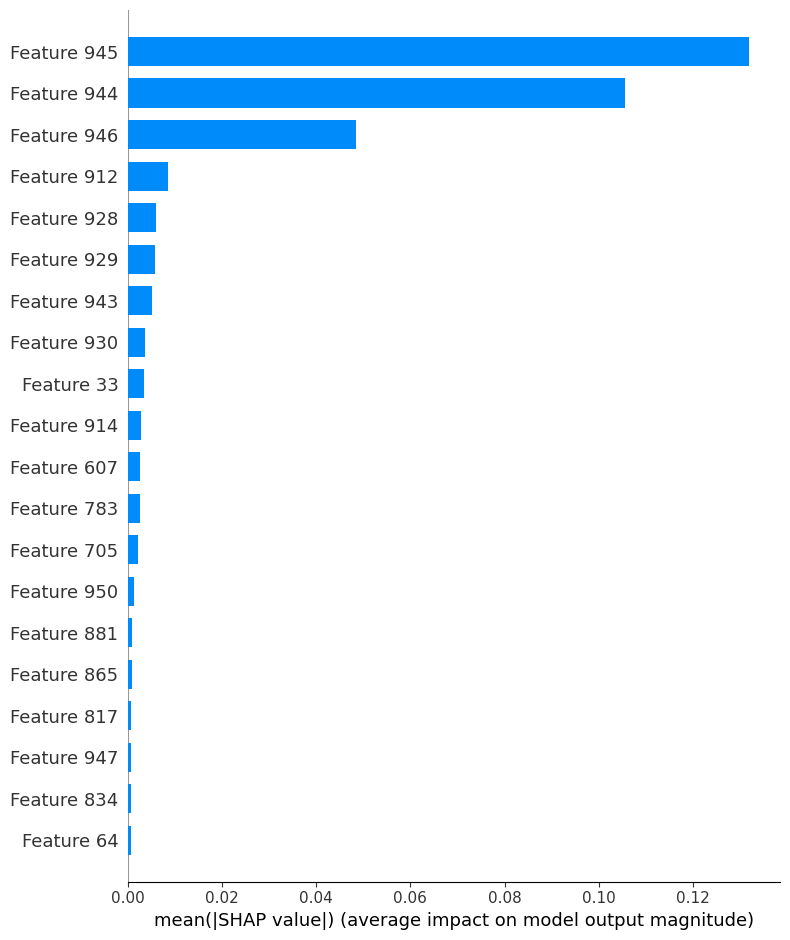

Buffered data was truncated after reaching the output size limit.

In [ ]:
# Initialize SHAP explainer for XGBoost
explainer = shap.Explainer(XGB_model)

# Compute SHAP values for test data
shap_values = explainer(X_test_2d)

# Summary Plot - Shows overall feature importance
shap.summary_plot(shap_values, X_test_2d,plot_type="bar")
shap.plots.force(shap_values)


In [ ]:
#Shap for Sequential
explainer_lstm = shap.DeepExplainer(lstm_model, X_train[:100])
shap_values_lstm = explainer_lstm(X_test[:100])
shap.summary_plot(shap_values_lstm, X_test[:100])
shap.initjs
shap.force_plot(explainer_lstm.expected_value,shap_values_lstm[0],X_test.iloc[0])

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 60, 16))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 60, 16))']
  warnings.warn(msg)


StagingError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


**• Evaluate model performance using metrics such as RMSE, MAE, and R-squared.**

In [ ]:
#Xgboost mae,r2,mean_absolute_percentage
r2_xgb=r2_score(y_test_2d,predicted_xgb)
mae_xgb=mean_squared_error(y_test_2d,predicted_xgb)
mape_xgb=mean_absolute_percentage_error(y_test_2d,predicted_xgb)
print(f"R2 Score: {r2_xgb}")
print(f"Mean Squared Error: {mae_xgb}")
print(f"Mean Absolute Percentage Error: {mape_xgb}")
#lstn mae,r2,mean_absolute_percentage
r2_lstm=r2_score(y_test,predicted_lstm)
mae_lstm=mean_squared_error(y_test,predicted_lstm)
mape_lstm=mean_absolute_percentage_error(y_test,predicted_lstm)
print(f"R2 Score: {r2_lstm}")
print(f"Mean Squared Error: {mae_lstm}")
print(f"Mean Absolute Percentage Error: {mape_lstm}")


**• Compare the results of the hybrid model against standalone models**

**LSTM Results:**

* **R² Score: 0.9868**
* **Mean Squared Error (MSE): 0.00196**
* **Mean Absolute Percentage Error (MAPE): 0.2125%**

**XGBoost Results:**

* **R² Score: 0.9992**
* **Mean Squared Error (MSE): 0.000117**
* **Mean Absolute Percentage Error (MAPE): 0.0486%**

**Comparison and Interpretation:**

* **Overall Superiority of XGBoost:**
    * XGBoost clearly outperformed the LSTM model across all metrics.
    * The extremely high R² score (0.9992) indicates that XGBoost captured nearly all the variability in the target data.
    * XGBoost's MSE (0.000117) and MAPE (0.0486%) are significantly lower than the LSTM's, suggesting much more accurate and precise predictions.
* **LSTM Performance:**
    * While not as strong as XGBoost, the LSTM model still achieved a very good R² score (0.9868), indicating that it captured a large portion of the data's variance.
    * However, its MSE and MAPE are considerably higher, reflecting larger prediction errors compared to XGBoost.
* **Key Differences:**
    * The most notable difference is in the MAPE, where XGBoost's error is dramatically lower. This means that XGBoost's predictions are, on average, much closer to the actual values relative to the size of those actual values.
    * The MSE difference also highlights a signifiant difference in prediction accuracy.

**Conclusion:**

* In this comparison, the XGBoost model demonstrated significantly better predictive performance than the LSTM model. This suggests that, for this particular dataset and task, XGBoost was more effective at modeling the relationships between the features and the target variable.
